### Step 4: Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# read in clean data file
ok_cupid_df = pd.read_csv('data/okcupid_profiles_clean.csv')
ok_cupid_df.columns

Index(['age', 'height', 'essay_len', 'male', 'is_religious', 'is_atheist',
       'gay', 'straight', 'available', 'seeing someone',
       ...
       'thai', 'tibetan', 'turkish', 'ukrainian', 'urdu', 'vietnamese',
       'yiddish', 'rotuman', 'welsh', 'days_since_last_online'],
      dtype='object', length=395)

In [4]:
ok_cupid_df.head(2)

,age,height,essay_len,male,is_religious,is_atheist,gay,straight,available,seeing someone,...,thai,tibetan,turkish,ukrainian,urdu,vietnamese,yiddish,rotuman,welsh,days_since_last_online
0,22,75.0,2389,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
1,35,70.0,1340,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3


#### Modelling:

For this project, the main modelling techniques are clustering while others (such as PLC, and TSNE) are simply for visualizations of different clusters. The main modelling techniques used were:

KMeans clustering
Agglomerative clustering

If they both indicate similar results, then perhaps I was on the right track. For all clusterings, I used the following procedure:

- Min-max scale non-oneHotEncoded or non-transformed features (age, height, essay_len, and days_since_last_online), since clustering algorithms are distance based and features which are one-hot-encoded have a higher chance of not being represented in the final outcome.
- Determine optimal number of clusters based on scree plots and silhouette scores (i.e. visual interpretation based on where the elbow lies).
- Analyze results based on: Crosstab of both labels, and adjusted_rand_score

### PCA

In [5]:
from sklearn.decomposition import PCA

# PCA to view potential clusters later
pca = PCA()
pca.fit(ok_cupid_df)
pc_df = pca.transform(ok_cupid_df)

In [6]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
expl_var = pca.explained_variance_ratio_

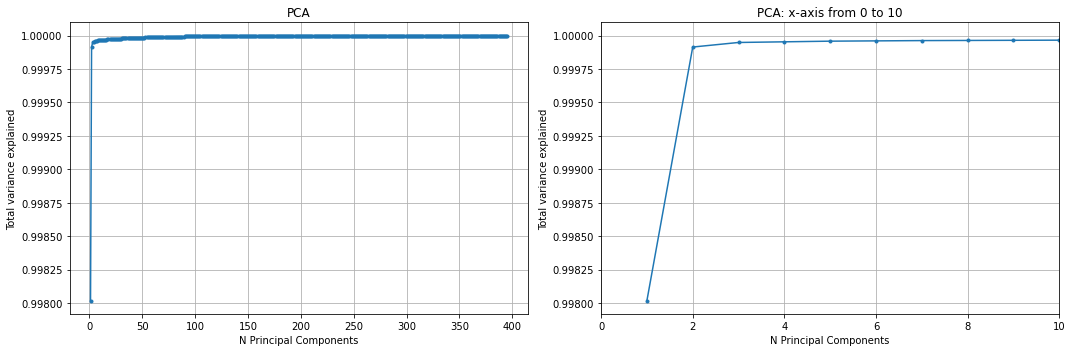

In [7]:
# examine plot for a potential elbow
plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,cumulative_sum.shape[0]+1), cumulative_sum, marker='.')
plt.xlabel('N Principal Components')
plt.ylabel('Total variance explained')
plt.title('PCA')
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,cumulative_sum.shape[0]+1), cumulative_sum, marker='.')
plt.xlabel('N Principal Components')
plt.ylabel('Total variance explained')
xlim1 = 0
xlim2 = 10
plt.title(f'PCA: x-axis from {xlim1} to {xlim2}')
plt.xlim(xlim1,xlim2)
plt.grid()
plt.tight_layout()
plt.show()

Very intersting to see an elbow at 2.

In [8]:
pca = PCA(n_components=2)
pc_df = pca.fit_transform(ok_cupid_df)

<Figure size 1800x1800 with 0 Axes>

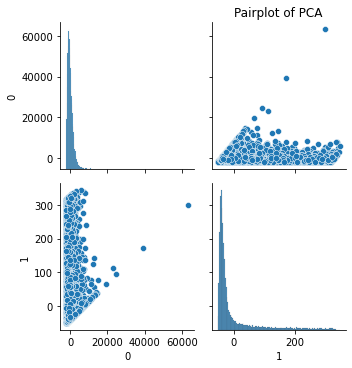

In [9]:
plt.figure(figsize=(25,25))
sns.pairplot(pd.DataFrame(pc_df))
plt.tight_layout()
plt.title("Pairplot of PCA")
plt.show()

TSNE

In [10]:
# import TSNE to vew clusters
from sklearn.manifold import TSNE

In [11]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(pc_df)

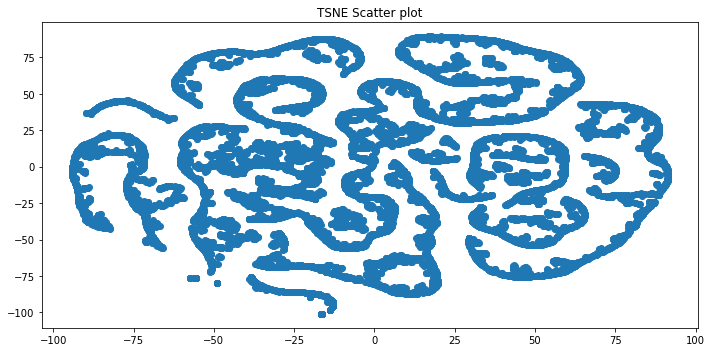

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.title('TSNE Scatter plot')
plt.tight_layout()
plt.show()

I believe this plot shows the differnt clusters and it's hard to tell how many clusters but definitely more than 3.

Scaling the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
# i did not want to restrict the values to between 0 and 1.
# Some label encodings go up quite higher than 1 and therefore 10 seemed like a good value
my_scaler = MinMaxScaler(feature_range=(0, 10))

# scale non-one-hot-encoded features
scaled_data = my_scaler.fit_transform(ok_cupid_df[['age', 'height', 'essay_len', 'days_since_last_online']])

# drop them from dataframe
df2 = pd.DataFrame(columns=['age', 'height', 'essay_len', 'days_since_last_online'], data=scaled_data)
df2.head()

,age,height,essay_len,days_since_last_online
0,0.784314,7.826087,0.362866,0.081081
1,3.333333,7.282609,0.202930,0.054054
2,2.549020,6.739130,0.174724,0.054054
3,3.725490,6.739130,0.315297,0.081081
4,1.960784,7.500000,0.655140,1.081081


In [15]:
# add scaled features back in dataframe
ok_cupid_df = ok_cupid_df.drop(columns = ['age', 'height', 'essay_len', 'days_since_last_online'])
ok_cupid_df = pd.concat([ok_cupid_df, df2], axis=1)

In [16]:
# assign daraframe to X for clusterings
X = ok_cupid_df

#### KMeans Clustering

In [17]:
from sklearn.cluster import KMeans

In [18]:
k_values = range(1, 30)
inertia_list = []

for k in k_values:
    
    # Create & fit kmeans model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    
    # Get inertia score and add to list
    inertia_list.append(kmeans.inertia_)

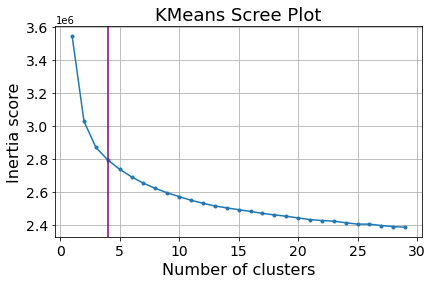

In [19]:
# Visualize the scree plot
plt.figure()
plt.plot(k_values, inertia_list, marker='.')
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Inertia score', fontsize=16)
plt.title('KMeans Scree Plot', fontsize=18)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x = 4, color = 'purple')
plt.show()

4 clusters seen above.

#### Silhouette Scores for KMeans

In [20]:
from sklearn.metrics import silhouette_score

# set a range to loop over
k_values = range(2, 10)

# create empty list for scores
silhouette_scores = []

for k in k_values:
    
    # Create & fit kmeans model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    
    # Get cluster labels and calculate the silhouette score
    cluster_labels = kmeans.labels_
    silhouette = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette)

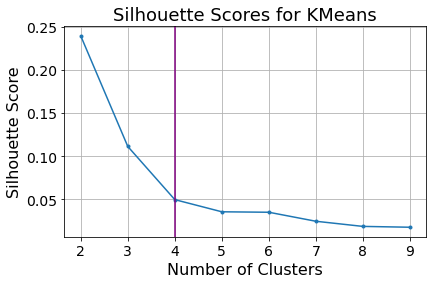

In [21]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='.')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=16)
plt.title('Silhouette Scores for KMeans', fontsize=18)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x = 4, color = 'purple')
plt.show()

Also 4 clusters seen above.

### Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
# follows similar pattern as KMeans

# create a range to loop over
k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    
    # Create & fit agglomerative model
    aggclust = AgglomerativeClustering(n_clusters=k)
    aggclust.fit(X)
    
    # Get cluster labels and calculate the silhouette score
    cluster_labels = aggclust.labels_
    silhouette = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette)

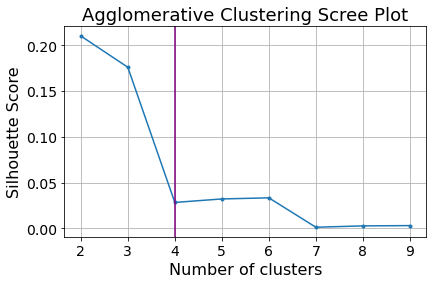

In [24]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='.')
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=16)
plt.title('Agglomerative Clustering Scree Plot', fontsize=18)
plt.grid()
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x = 4, color = 'purple')
plt.show()

#### Cluster Labels

In [25]:
kmeans_log = KMeans(n_clusters=4)
kmeans_log.fit(X)

# Create a new column in the dataset to hold the kmeans cluster label
ok_cupid_df['kmeans_label'] = kmeans_log.labels_

In [26]:
aggclust_log = AgglomerativeClustering(n_clusters = 4)
aggclust_log.fit(X)

ok_cupid_df['agg_label'] = aggclust_log.labels_

In [27]:
ok_cupid_df.head(2)

,male,is_religious,is_atheist,gay,straight,available,seeing someone,single,banking / financial / real estate,clerical / administrative,...,vietnamese,yiddish,rotuman,welsh,age,height,essay_len,days_since_last_online,kmeans_label,agg_label
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.784314,7.826087,0.362866,0.081081,1,2
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,3.333333,7.282609,0.202930,0.054054,3,1


PLC plots using cluster labels

In [28]:
pc_df = pd.DataFrame(pc_df)
pc_df['kmeans_labels'] = kmeans_log.labels_
pc_df['agg_labels'] = aggclust_log.labels_

<Figure size 1800x1800 with 0 Axes>

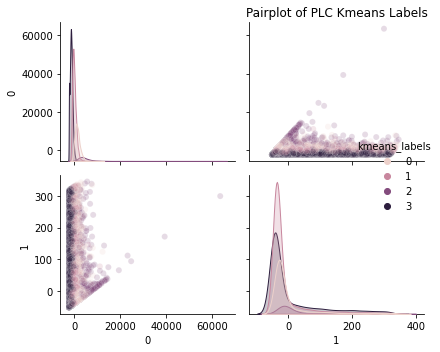

In [29]:
plt.figure(figsize=(25,25))
sns.pairplot(pc_df.drop(columns='agg_labels'), hue='kmeans_labels', plot_kws={'alpha': 0.2})
plt.title("Pairplot of PLC Kmeans Labels")
plt.tight_layout()
plt.show()

<Figure size 1800x1800 with 0 Axes>

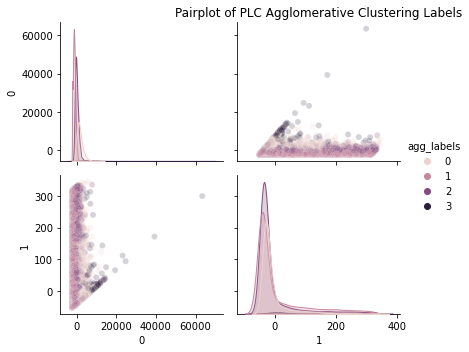

In [30]:
plt.figure(figsize=(25,25))
sns.pairplot(pc_df.drop(columns='kmeans_labels'), hue='agg_labels', plot_kws={'alpha': 0.2})
plt.title("Pairplot of PLC Agglomerative Clustering Labels")
plt.tight_layout()
plt.show()

#### TSNE Plots using cluster labels:

In [31]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(pc_df)

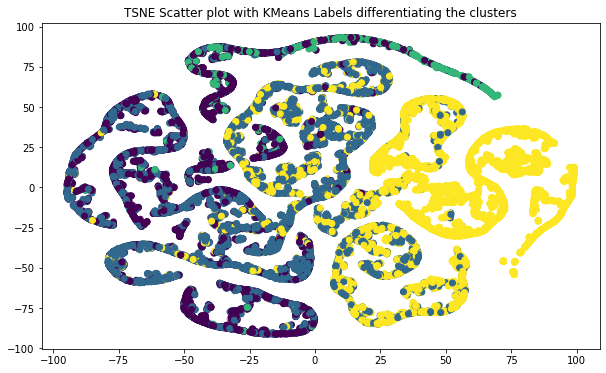

In [33]:
plt.figure(figsize=(10,6))
plt.title('TSNE Scatter plot with KMeans Labels differentiating the clusters')
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=pc_df['kmeans_labels'])
plt.show()

While not extremely accurate, the plot is trying to illustrate clusters and colouring them accordingly.

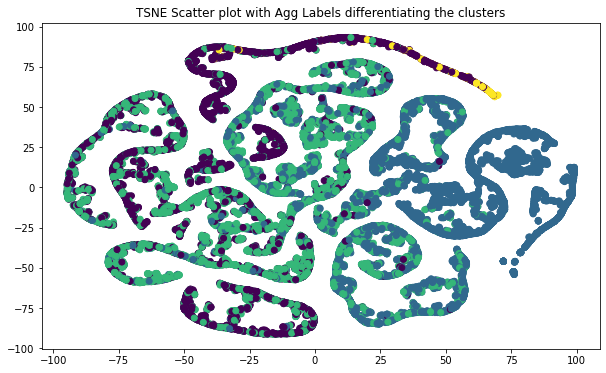

In [34]:
plt.figure(figsize=(10,6))
plt.title('TSNE Scatter plot with Agg Labels differentiating the clusters')
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=pc_df['agg_labels'])
plt.show()

The plot above seems to be showing the same amount of clusters.

Distribution of data in each cluster:

In [35]:
# create table to understand how the data is distributed for each label
crosstab_kmeans = pd.crosstab(ok_cupid_df['kmeans_label'], ok_cupid_df['agg_label'])
crosstab_kmeans

agg_label,0,1,2,3
kmeans_label,,,,
0,2903,0,729,1
1,847,717,5706,0
2,607,0,1,157
3,8,6330,514,0


In [36]:
# check percentage of data distribution for each cluster
crosstab_agg = round(pd.crosstab(ok_cupid_df['kmeans_label'], ok_cupid_df['agg_label']) / len(ok_cupid_df)*100,2)
crosstab_agg

agg_label,0,1,2,3
kmeans_label,,,,
0,15.67,0.00,3.94,0.01
1,4.57,3.87,30.81,0.00
2,3.28,0.00,0.01,0.85
3,0.04,34.18,2.78,0.00


Adjusted Rand Score:

In [37]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(ok_cupid_df['kmeans_label'], ok_cupid_df['agg_label'])

0.5840554612572568

To summarize the results:

All clusterings indicate 4 clusters based on where ‘elbow’ occurs (the purple line is drawn for reference):

The adjusted_rand_score was 0.58 which means that the clusterings are in some agreement. The crosstab illustrates that majority of the data falls within groups 1 and 2 (while also not being diagonal or cross-diagonal) which is not a bad thing but it would be ideal to have the data separated evenly across all labels. For reference 34.18% of data is in column 1 (row 3), and 30.81% is in column 2 (row 1).

#### Conclusion

In conclusion, this data offers limited insights in order to find meaningful clusters, and make meaningful recommendations. I was able to find clusters but they are certainly not meaningful. I think the fact that this data had to be transformed so drastically perhaps led to the results being less meaningful. Additionally, it can also be said that with so many missing values, the data itself was not great.